<a href="https://colab.research.google.com/github/aliaghababaee/SLO_Asieh/blob/main/merged_model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!unzip /content/drive/MyDrive/merged_data_final2.zip

Archive:  /content/drive/MyDrive/merged_data_final2.zip
replace test_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged.pkl         
replace test_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged_label.pkl   
replace train_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train_merged.pkl        
replace train_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: train_merged_label.pkl  


In [8]:
!unzip /content/drive/MyDrive/new_test_merged_data.zip

Archive:  /content/drive/MyDrive/new_test_merged_data.zip
replace test_merged.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged.pkl         
replace test_merged_label.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
 extracting: test_merged_label.pkl   


In [ ]:
%cd '/content/drive/MyDrive/Slo_classification'

/content/drive/MyDrive/Slo_classification


In [9]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold (n_splits = 5, shuffle = True, random_state = None)

In [10]:
import tensorflow as tf
from keras.layers import Input
import numpy as np
import pickle
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import ConfusionMatrixDisplay

In [21]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_oct (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 5, # rotation
        zoom_range= 0.2,
        vertical_flip= True , # vertical fli
        fill_mode='nearest',
        data_format='channels_last',
        #cval=0,
          )


    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [22]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator


def Augmentation_slo (x_train, labels_train):

    # augmentation
    batch=np.zeros_like(x_train, dtype=np.float32)
    batch_label=np.zeros_like(labels_train, dtype=np.float32)

    datagen = ImageDataGenerator(
        rotation_range= 5, # rotation
        width_shift_range= [-30, 30], # horizontal shift
        height_shift_range= [-5, 5] , # vertical shift
        zoom_range= 0.2,
        vertical_flip= True , # vertical flip
        brightness_range= [0.2, 1.5],
          )

    for i in range(len(x_train)):
        x1=x_train[i,:,:,:].copy()
        x1=x1.reshape((1, ) + x1.shape)
        x = datagen.flow(x1, batch_size=1, seed=2020) # to make the result reproducible


        batch[i,:,:,:] = x.next()
        batch_label[i] = labels_train[i]

    ###################################################################
    # Final data
    ###################################################################

    x = np.concatenate([x_train,batch])

    labels = np.concatenate([labels_train,batch_label])

    ############################

    ############################
    return x, labels

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve, auc
import numpy as np
from sklearn import metrics
import sklearn

# TP = confusion[1,1] # true positive
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

def metrics_calculation(y_valid, y_pred, y_prob):

    #####################################################
    #Get the confusion matrix
    #####################################################
    ROC_AUC = roc_auc_score(y_valid, y_prob)
    f1 = metrics.f1_score(y_valid, y_pred, average='weighted')
    precision, recall, thresholds = precision_recall_curve(y_valid, y_prob)
    P_R_AUC = auc(recall, precision)
    cm = sklearn.metrics.confusion_matrix(y_valid, y_pred, normalize='pred')
    #Now the normalize the diagonal entries
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_acc = cm.diagonal()

    Specificity = cm[0,0]/(cm[0,0]+cm[0,1])
    Sensitivity = cm[1,1]/(cm[1,0]+cm[1,1])
    Precision   = cm[1,1]/(cm[0,1]+cm[1,1])


    return Specificity, Sensitivity, Precision, f1, ROC_AUC, P_R_AUC, class_acc, cm

In [14]:
import numpy as np
from sklearn.metrics import precision_recall_curve, auc

def curve_ploting(ax, axx, mean_fpr, aucs, tprs, y_test, y_pred, classifier, kernel=[]):

    ###################### Continuing Ploting ROC curve for each fold and the mean ############

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
    )

    if kernel:
        ax.set_title(f"ROC Curve of {classifier} classifier ({kernel} kernel) ")
    else:
        ax.set_title(f"ROC Curve of {classifier} classifier")
    ax.legend(loc="lower right")

    ###################### Continuing Ploting P_R_curve for each fold and the mean ############
    ###

    no_skill = len(np.array(y_test)[np.array(y_test)==1]) / len(np.array(y_test))

    axx.plot([0, 1], [no_skill, no_skill], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    precision, recall, _ = precision_recall_curve(y_test, y_pred)

    axx.plot(
        recall,
        precision,
        color="b",
        label=r"Mean P_R curve (AUC =  %0.2f)" % (auc(recall, precision)),
        lw=2,
        alpha=0.8,
    )


    # axis labels
    axx.set_xlabel('Recall')
    axx.set_ylabel('Precision')
    # show the legend
    axx.legend(loc="lower left")
    if kernel:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier ({kernel} kernel)')
    else:
        axx.set_title(f'Precision-Recall Curve of {classifier} classifier')

In [15]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
import numpy as np

def fold_curves(ax, axx, y_valid, fold_number, mean_fpr, pred_proba, tprs=[], aucs=[]):
    ############ ROC Curve
    lr_fpr, lr_tpr, _ = roc_curve(y_valid, pred_proba)
    roc_auc = roc_auc_score(y_valid, pred_proba)
    ax.plot(lr_fpr, lr_tpr, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, roc_auc))
    # axis labels
    ax.set_xlabel('False Positive Rate (Positive label: 1.0)')
    ax.set_ylabel('True Positive Rate (Positive label: 1.0)')

    interp_tpr = np.interp(mean_fpr, lr_fpr, lr_tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)


    ############ P_R Curve
    precision, recall, _ = precision_recall_curve(y_valid, pred_proba)
    # plot the model precision-recall curve
    axx.plot(recall, precision, lw=1, alpha=0.3, label=r"P_R_curve fold %d (AUC =  %0.2f)" % (fold_number, auc(recall, precision)))

    return tprs, aucs

In [16]:
### SLO model
from tensorflow.keras.models import Model
import tensorflow as tf
slo_model =  tf.keras.applications.resnet.ResNet101(
    weights='imagenet',
    include_top=False,
    input_shape=(128,128,3),
    )

for layer in slo_model.layers:
    layer._name = 'SLO_' + layer.name

new_model = Model(inputs=slo_model.input, outputs=slo_model.output)

new_model.save('slo_model_resnet101.h5')

171446536/171446536 [==============================] - 1s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
input_img_oct

NameError: name 'input_img_oct' is not defined

In [23]:
# merged CNN model for SLO and OCT images

# Create two CNN models with the same fully connected layers
from tensorflow.keras.models import load_model


def merged_model(input_img_slo ,input_img_oct):

    ### SLO model
    slo_model = load_model('slo_model_resnet101.h5')

    for layer in slo_model.layers:
        layer.trainable = False


    #OCT model

    oct_model =  tf.keras.applications.resnet.ResNet101(
        weights='imagenet',
        include_top=False,
        input_shape=input_img_oct,
        )


    oct_model.get_layer(index = 0)._name = 'OCT'

    for layer in oct_model.layers:
        layer.trainable = False


    inputs_slo = tf.keras.layers.Input(input_img_slo)
    slo_output = tf.keras.layers.Flatten()(slo_model(inputs_slo))


    inputs_oct = tf.keras.layers.Input(input_img_oct)
    oct_output = tf.keras.layers.Flatten()(oct_model(inputs_oct))


    model = tf.keras.layers.Concatenate(axis=-1)([slo_output, oct_output])


    model = tf.keras.layers.Dropout(0.6)(model)

    model = tf.keras.layers.Dense(3477, activation='relu')(model)

    model = tf.keras.layers.Dropout(0.4)(model)

    #model = tf.keras.layers.Dense(16, activation='relu')(model)

    #model = tf.keras.layers.Dropout(0.4)(model)


    #model = tf.keras.layers.Dense(3316, activation='relu')(model)


    outputs = tf.keras.layers.Dense(1, 'sigmoid')(model)

    model_merged = tf.keras.Model([inputs_slo, inputs_oct] , outputs)

    print(model_merged.summary())

    return model_merged


In [24]:
import numpy as np

def preparing(x, y):

    data_slo  = []
    data_oct  = []
    label     = []
    for i in x:
      for j in range(len(x[i])):
          data_slo.append(np.array(x[i][j][0])/255)
          data_oct.append(np.array(x[i][j][1])*255)
          label.append(y[i])
    data_slo = np.reshape(data_slo, np.shape(data_slo))
    data_oct = np.reshape(data_oct, np.shape(data_oct))
    return data_slo, data_oct, np.array(label)

---------------------------------------------------------------------          
 			 1th fold 
---------------------------------------------------------------------




Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_19 (InputLayer)       [(None, 60, 256, 3)]         0         []                            
                                                                                                  
 model (Functional)          (None, 4, 4, 2048)           4265817   ['input_18[0][0]']            
                                                          6                                       
                                                                                                  
 resnet101 (Functional)      (None, 2, 8, 2048)           4265817   ['input_19[0][0]']      

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, 60, 256, 3)]         0         []                            
                                                                                                  
 model (Functional)          (None, 4, 4, 2048)           4265817   ['input_21[0][0]']            
                                                          6                                       
                                                                                                  
 resnet101 (Functional)      (None, 2, 8, 2048)           4265817   ['input_22[0][0]']      

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_24 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_25 (InputLayer)       [(None, 60, 256, 3)]         0         []                            
                                                                                                  
 model (Functional)          (None, 4, 4, 2048)           4265817   ['input_24[0][0]']            
                                                          6                                       
                                                                                                  
 resnet101 (Functional)      (None, 2, 8, 2048)           4265817   ['input_25[0][0]']      

ResourceExhaustedError: Graph execution error:

Detected at node Adam/StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-25-8e720ad14cb6>", line 142, in <cell line: 66>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 544, in minimize

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1223, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1253, in _internal_apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1345, in _distributed_apply_gradients_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/optimizer.py", line 1340, in apply_grad_to_update_var

Out of memory while trying to allocate 1822949508 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    3.40GiB
              constant allocation:         8B
        maybe_live_out allocation:    2.55GiB
     preallocated temp allocation:    1.70GiB
  preallocated temp fragmentation:       124B (0.00%)
                 total allocation:    5.09GiB
Peak buffers:
	Buffer 1:
		Size: 869.25MiB
		XLA Label: fusion
		Shape: f32[65536,3477]
		==========================

	Buffer 2:
		Size: 869.25MiB
		XLA Label: fusion
		Shape: f32[65536,3477]
		==========================

	Buffer 3:
		Size: 869.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,3477]
		==========================

	Buffer 4:
		Size: 869.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,3477]
		==========================

	Buffer 5:
		Size: 869.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,3477]
		==========================

	Buffer 6:
		Size: 869.25MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[65536,3477]
		==========================

	Buffer 7:
		Size: 24B
		Operator: op_type="AssignSubVariableOp" op_name="AssignSubVariableOp" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: fusion
		Shape: (f32[65536,3477], f32[65536,3477], f32[65536,3477])
		==========================

	Buffer 8:
		Size: 8B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: s64[]
		==========================

	Buffer 9:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 10:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160 deduplicated_name="fusion.4"
		XLA Label: fusion
		Shape: f32[]
		==========================

	Buffer 11:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow_1" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================

	Buffer 12:
		Size: 4B
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[]
		==========================

	Buffer 13:
		Size: 4B
		Operator: op_type="Pow" op_name="Pow" source_file="/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/ops.py" source_line=1160
		XLA Label: constant
		Shape: f32[]
		==========================


	 [[{{node Adam/StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_654365]

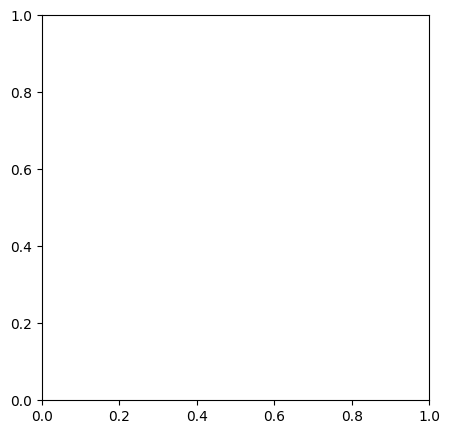

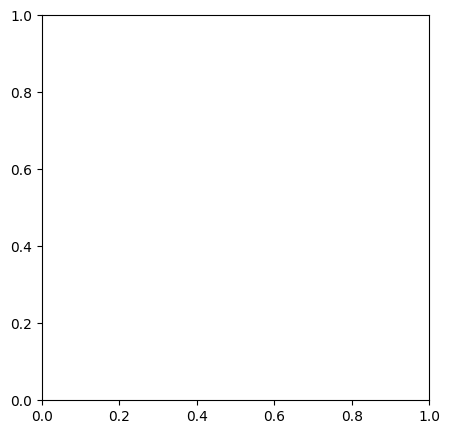

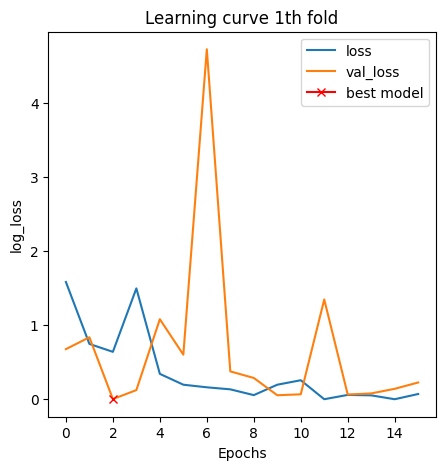

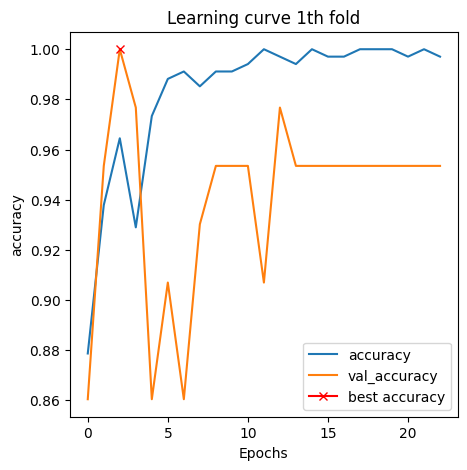

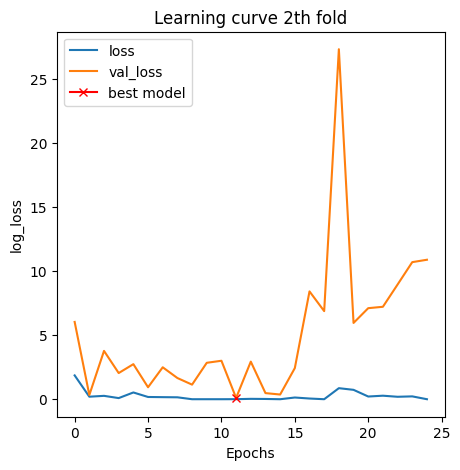

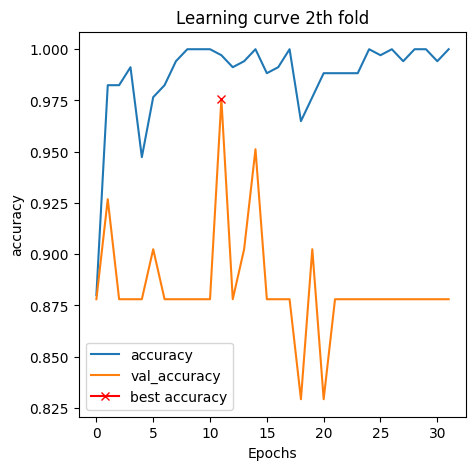

In [25]:
#from tensorflow_model_optimization.sparsity import keras as sparsity
images_train = pickle.load(open("train_merged.pkl", 'rb'))
labels_train = pickle.load(open("train_merged_label.pkl", 'rb'))

images_test = pickle.load(open("test_merged.pkl", 'rb'))
labels_test = pickle.load(open("test_merged_label.pkl", 'rb'))

images_test_slo, images_test_oct, labels_test_slo = preparing(images_test,labels_test)

images_test_slo = np.repeat (images_test_slo, repeats = 3, axis = 3)
images_test_oct = np.repeat (images_test_oct, repeats = 3, axis = 3)
#####################################################################
## Parameters
#####################################################################
channel = 3
number_class = 2

cnn_acc    = []
cnn_se     = []
cnn_sp     = []
cnn_pr     = []
cnn_f1     = []
cnn_auc    = []
cnn_pr_auc = []

test_acc    = []
test_se     = []
test_sp     = []
test_pr     = []
test_f1     = []
test_auc    = []
test_pr_auc = []


class_acc = np.zeros((number_class))
class_acc_test = np.zeros((number_class))

target_names = ['Normal' , 'MS']
confusion_matrix = np.zeros((number_class, number_class))
confusion_matrix_test = np.zeros((number_class, number_class))

y_test = []
tprs   = []
aucs   = []
y_pred = []
x_test = {}

mean_fpr  = np.linspace(0, 1, 100)
fig, ax   = plt.subplots(figsize=(5, 5))
fig1, ax1 = plt.subplots(figsize=(5, 5))


#### model parameters
batch_size        = 8
epoch             = 100
learning_rate     =  0.0004420657653222665
#####################################################################
## Applying kfold
#####################################################################

nfold = 5  #please enter number of folds

kf_nfold = StratifiedKFold(n_splits=nfold, random_state=42, shuffle=True)

n = 0
for train_index, val_index in kf_nfold.split(images_train,list(labels_train.values())):
    n = n+1
    # print(train_index, val_index)  # you can watch train and validation index using this comment
    print(f'---------------------------------------------------------------------\
          \n \t\t\t {n}th fold \n---------------------------------------------------------------------'\
          ,end = '\n\n\n' )
    x_train = {i: images_train[list(images_train.keys())[i]] for i in train_index}
    x_valid = {i: images_train[list(images_train.keys())[i]] for i in val_index}

    y_trainn = {i: labels_train[list(labels_train.keys())[i]] for i in train_index}
    y_validd = {i: labels_train[list(labels_train.keys())[i]] for i in val_index}


    ################## preparing

    x_train_slo, x_train_oct, y_train = preparing(x_train,y_trainn)
    x_valid_slo, x_valid_oct, y_valid = preparing(x_valid,y_validd)

    x_test[n] = x_valid_slo
    ################# Augmentation
    x_train_slo, y_train_slo = Augmentation_slo(x_train_slo,y_train)

    x_train_oct, y_train_oct = Augmentation_oct(x_train_oct,y_train)


    indices = np.random.permutation (len (x_train_slo))
    x_train_slo = x_train_slo [indices]
    y_train_slo = y_train_slo [indices]

    x_train_oct = x_train_oct [indices]
    y_train_oct = y_train_oct [indices]


    x_train_slo = np.repeat (x_train_slo, repeats = 3, axis = 3)

    x_train_oct = np.repeat (x_train_oct, repeats = 3, axis = 3)

    x_valid_slo = np.repeat (x_valid_slo, repeats = 3, axis = 3)

    x_valid_oct = np.repeat (x_valid_oct, repeats = 3, axis = 3)

    ####################################################################
    # classification
    ####################################################################

    input_img_slo = (np.shape(x_train_slo)[1], np.shape(x_train_slo)[2], 3)
    input_img_oct = (np.shape(x_train_oct)[1], np.shape(x_train_oct)[2], 3)

    model = merged_model(input_img_slo=input_img_slo, input_img_oct=input_img_oct)

    METRICS = [
#      keras.metrics.TruePositives(name='tp'),
#      keras.metrics.FalsePositives(name='fp'),
#      keras.metrics.TrueNegatives(name='tn'),
#      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
#      keras.metrics.Precision(name='precision'),
#      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
#      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
      ]


    my_optimizer =  tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=my_optimizer, loss="binary_crossentropy", metrics=METRICS)
    callbacks = [EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=10, min_lr=1e-6),
        ModelCheckpoint(f'slo_oct{n}.h5', verbose=1, save_best_only=True, save_weights_only=True)]

    model.summary()

    #################################
    ###### Applying model  ###########
    #################################


    results = model.fit([x_train_slo, x_train_oct], y_train_slo, batch_size=batch_size, epochs=epoch, callbacks=callbacks,\
                    validation_data=([x_valid_slo, x_valid_oct], np.asarray(y_valid, dtype=np.float64)))

    #pruning_params = {
        #'pruning_schedule': sparsity.PolynomialDecay (initial_sparsity = 0.5, final_sparsity = 0.9, begin_step = 0, end_step = 1000)
    #}

    #pruned_model = sparsity.prune_low_magnitude (model, **pruning_params)

    #pruned_model.compile (optimizer = my_optimizer, loss = 'binary_crossentropy', metrics = METRICS)
    #pruned_model.fit (x_train, epochs)

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["loss"][:-7], label="loss")
    plt.plot(results.history["val_loss"][:-7], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend()

    plt.figure(figsize=(5, 5))
    plt.title(f"Learning curve {n}th fold")
    plt.plot(results.history["accuracy"], label="accuracy")
    plt.plot(results.history["val_accuracy"], label="val_accuracy")
    plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]),\
             marker="x", color="r", label="best accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.legend()


    # load the best model
    model.load_weights(f'slo_oct{n}.h5')


    pred_proba = model.predict([x_valid_slo, x_valid_oct]).ravel()
    pred_class = (pred_proba > 0.5).astype(np.uint8)


    ##### calculating metrics

    cnn_acc.append(metrics.accuracy_score(y_valid, pred_class))
    print(f'accuracy of {n}th fold : {metrics.accuracy_score(y_valid, pred_class)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(y_valid, pred_class, pred_proba)

    cnn_sp.append(SP)
    cnn_se.append(SE)
    cnn_pr.append(PR)
    cnn_f1.append(f1)
    cnn_auc.append(ROC_AUC)
    cnn_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc = np.add(class_acc,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix = np.add(confusion_matrix,cm)

######################## internal test
    pred_proba_test = model.predict([images_test_slo, images_test_oct]).ravel()
    pred_class_test = (pred_proba_test > 0.5).astype(np.uint8)


    ##### calculating metrics

    print(f'test accuracy of {n}th fold : {metrics.accuracy_score(labels_test_slo, pred_class_test)}')
    SP, SE, PR, f1, ROC_AUC, P_R_AUC, Class_acc, cm = metrics_calculation(labels_test_slo, pred_class_test, pred_proba_test)
    test_acc.append(metrics.accuracy_score(labels_test_slo, pred_class_test))
    test_sp.append(SP)
    test_se.append(SE)
    test_pr.append(PR)
    test_f1.append(f1)
    test_auc.append(ROC_AUC)
    test_pr_auc.append(P_R_AUC)

    #################### acc for each class ##################
    class_acc_test  = np.add(class_acc_test,Class_acc)

    ###################### Total confusion_matrix for poly kernel ############
    confusion_matrix_test = np.add(confusion_matrix_test,cm)

    # ###################### Ploting ROC and PR curves for each fold ############
    # y_test = np.append(y_test, y_valid, axis = 0)
    # y_pred = np.append(y_pred, pred_proba, axis = 0)
    # ###
    # tprs, aucs = fold_curves(ax, ax1, y_valid, n, mean_fpr, pred_proba, tprs, aucs)

# ######################  the mean Ploting ROC and PR curves ############
# ###
# curve_ploting(ax, ax1, mean_fpr, aucs, tprs, y_test, y_pred, 'CNN' )

# plt.show()

# #######################################
#     # ploting confusion matrix
# #######################################
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix/nfold, display_labels=target_names)
# disp.plot()


########################################
#     Metrics printing
########################################
cnn_accc     = np.mean(cnn_acc)
cnn_spp      = np.mean(cnn_sp)
cnn_see      = np.mean(cnn_se)
cnn_prr      = np.mean(cnn_pr)
cnn_f11      = np.mean(cnn_f1)
cnn_aucc     = np.mean(cnn_auc)
cnn_pr_aucc  = np.mean(cnn_pr_auc)

###################### internal test
test_accc     = np.mean(test_acc)
test_spp      = np.mean(test_sp)
test_see      = np.mean(test_se)
test_prr      = np.mean(test_pr)
test_f11      = np.mean(test_f1)
test_aucc     = np.mean(test_auc)
test_pr_aucc  = np.mean(test_pr_auc)

#################### acc for each class ##################
class_acc  = class_acc/nfold
class_acc_test  = class_acc_test/nfold

print('cnn_acc     = %f' % cnn_accc)
print('cnn_sp      = %f' % cnn_spp)
print('cnn_se      = %f' % cnn_see)
print('cnn_pr      = %f' % cnn_prr)
print('cnn_f1      = %f' % cnn_f11)
print('cnn_auc     = %f' % cnn_aucc)
print('cnn_pr_auc  = %f' % cnn_pr_aucc, end='\n\n')


print('acc of class %s' % target_names[0], '= %f' % class_acc[0])
print('acc of class %s' % target_names[1], '= %f' % class_acc[1], end='\n\n')

print('test_acc     = %f' % test_accc)
print('test_sp      = %f' % test_spp)
print('test_se      = %f' % test_see)
print('test_pr      = %f' % test_prr)
print('test_f1      = %f' % test_f11)
print('test_auc     = %f' % test_aucc)
print('test_pr_auc  = %f' % test_pr_aucc, end='\n\n')


print('test acc of class %s' % target_names[0], '= %f' % class_acc_test[0])
print('test acc of class %s' % target_names[1], '= %f' % class_acc_test[1], end='\n\n')